In [32]:
#!pip install packaging
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from packaging import version
import time

assert(version.parse(tf.__version__) >= version.parse("2.0.0-aplha"))

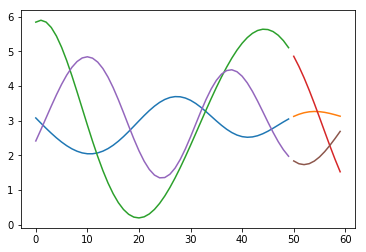

In [33]:
def generate_serie(size, step) :
    maxT = size*step
    t = np.arange(0, maxT, step)
#    return (np.sin(t+np.cos(t*0.31))).astype(np.float32)
    return ((np.sin(t+np.sin(t*.31)) * np.sin(t /10 / 3.3485)).astype(np.float32)+1)*3
#    return (np.sin(t+np.cos(t)) + .34158*np.sin(t * 3.3485)).astype(np.float32)
#return (t * np.sin(t)/maxT + .3*np.sin(t * 3.3)).astype(np.float32)

def split(arr, *count) :
    total = sum(count)
    p0 = 0
    for i in count :
        p1 = p0 + i
        yield arr[int(len(arr)*p0/total):int(len(arr)*p1/total)]
        p0 = p1
    
    
np.random.seed(42)

SEQ_LEN = 10
N_STEPS = 50
data = generate_serie(14001, .18)
data = [(data[i:i+N_STEPS], data[i+N_STEPS:i+N_STEPS+SEQ_LEN]) for i in range(len(data)-N_STEPS-SEQ_LEN)] 

np.random.shuffle(data)

#plt.plot(data[1][0])
#plt.plot(data[2][0])
#plt.plot(data[3][0])
#plt.show()

spt_data = np.reshape([data[i][0] for i in range(len(data))], (-1, N_STEPS, 1))
spt_lbl = np.reshape([data[i][1] for i in range(len(data))], (-1, SEQ_LEN, 1))

train_size = 70
valid_size = 20
test_size = 10

[train, valid, test] = zip(split(spt_data, train_size, valid_size, test_size), 
                           split(spt_lbl, train_size, valid_size, test_size))

plt.plot(range(N_STEPS), train[0][1])
plt.plot(range(N_STEPS, N_STEPS+SEQ_LEN), train[1][1])
plt.plot(range(N_STEPS), train[0][2])
plt.plot(range(N_STEPS, N_STEPS+SEQ_LEN), train[1][2])
plt.plot(range(N_STEPS), train[0][3])
plt.plot(range(N_STEPS, N_STEPS+SEQ_LEN), train[1][3])
plt.show()

train = tf.data.Dataset.from_tensor_slices((train[0], train[1]))
valid = tf.data.Dataset.from_tensor_slices((valid[0], valid[1]))
test = tf.data.Dataset.from_tensor_slices((test[0], test[1]))
#train = train.batch(64, True)
#valid = valid.batch(64, True)
#test = test.batch(64, True)


In [34]:
class Encoder(tf.keras.Model):
  def __init__(self, hidden1, enc_units, batch_sz, seq_len) : #, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.hidden1 = hidden1
    self.enc_units = enc_units
    self.batch_sz = batch_sz
    self.seq_len = seq_len

    self.encoder = tf.keras.layers.LSTM(self.hidden1,
                                    #return_sequences=True,
                                    return_state=True,
                                    stateful= not True,
                                    #activation="relu",
                                    #activation="selu",
                                    #activation="linear",
                                    #recurrent_activation="selu",  
                                       )#recurrent_initializer='glorot_uniform')
    
    self.decoder = tf.keras.layers.LSTM(self.hidden1,
                                    return_sequences=True,
                                    #return_state=True,
                                    stateful=not True,
                                    #activation="relu",
                                    #activation="selu",
                                    #activation="linear",
                                    #recurrent_activation="selu",  
                                    recurrent_initializer='glorot_uniform')
    self.dense = tf.keras.layers.Dense(self.enc_units,
                                    activation="linear")

    
#  def call(self, x, initial_state=None): #, hidden):
  def call(self, x) :
    mean = tf.keras.backend.mean(x, [1], True)
    var = tf.keras.backend.var(x, [1], True)
    x = (x - mean) / tf.keras.backend.sqrt(var)
    
    #return x
#    [_, state, _] = self.encoder(x)
    #[o, state1, state2] = self.encoder(x)
    output = self.encoder(x)
    state = output[1:]
    #toto = self.encoder(x)
#    print("++++++++++++++")
#    print(o)
#    print("--------------")
#    print(state1)
#    print("--------------")
#    print(state2)
#    print("--------------")
    #print(o)
    #print("--------------")
    #print(state)
    #print("--------------")
    #print(o2)
#    print(self.encoder.states)
#    print("--------------")
    #print("--------------")
    #print(self.encoder.states)
    
#    state = tf.compat.v1.nn.rnn_cell.LSTMStateTuple(state1, state2)
#    print(state)
#    print("--------------")
    
    d = tf.zeros([self.batch_sz, self.seq_len, self.enc_units])
#    d = tf.zeros([1, 2, 3])
    x = self.decoder(d, initial_state=state)
#    x = self.decoder(d, initial_state=state2)
#    x = self.decoder(d, initial_state=[state1, state2])
#    x = self.decoder(d, initial_state=self.encoder.states)
    x = self.dense(x)
    x = x * tf.keras.backend.sqrt(var) + mean
    return x

#  def reset_states(self) :
#    self.lstm.reset_states()

#  def reset_states(self, initial_state=None) :
#    #print(self.lstm.input_spec)
#    self.lstm.reset_states(initial_state)

#  def initialize_hidden_state(self):
#    return tf.zeros((self.batch_sz, self.enc_units))
 

In [35]:
### Test

BATCH_SIZE = 8

encoder = Encoder(30, 1, BATCH_SIZE, SEQ_LEN)
#encoder.reset_states(tf.compat.v1.nn.rnn_cell.LSTMStateTuple(8,30))
#a = encoder.encoder.get_initial_state(tf.keras.Input(shape=(50, 1)))
#a = encoder.encoder.get_initial_state(list(test.batch(BATCH_SIZE, True))[0])
#print(a)
encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
encoder.summary()
encoder.compile(optimizer="Adam", loss="MSE", metrics=['accuracy'])
encoder(tf.keras.Input(shape=(50, 1)))
print("stateful", encoder.stateful, encoder.state_updates)
print("encoder", encoder.input_shape, encoder.output_shape)
#print("lstm", encoder.lstm.input_shape, encoder.lstm.output_shape)
#print("dense", encoder.dense.input_shape, encoder.dense.output_shape)

val = encoder.predict(test.batch(BATCH_SIZE, True))

plt.figure(figsize=(15.0,10.0))
plt.plot(np.zeros(50), color='k')

colors = ['b','g','r']
for i in range(0,3) :
    plt.plot(list(test)[i][0], label="s0_" + str(i), linestyle=':', color=colors[i])
#    plt.plot(list(test)[i][1], label="s1_" + str(i))
    plt.plot(val[i], label="p_" + str(i), linestyle='-', color=colors[i])
#    plt.plot(val0[i], label="p_" + str(i), linestyle='-')
#    plt.plot(val1[i], label="p_" + str(i), linestyle='--')
plt.legend()
plt.show()


Model: "encoder_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_12 (UnifiedLSTM multiple                  3840      
_________________________________________________________________
unified_lstm_13 (UnifiedLSTM multiple                  3840      
_________________________________________________________________
dense_6 (Dense)              multiple                  31        
Total params: 7,711
Trainable params: 7,711
Non-trainable params: 0
_________________________________________________________________
stateful False []
encoder (None, 50, 1) (8, 10, 1)


KeyboardInterrupt: 

In [ ]:
BATCH_SIZE = 64 #*8

#encoder = Encoder(10, N_STEPS, BATCH_SIZE)
encoder = Encoder(4, 1, BATCH_SIZE, SEQ_LEN)
encoder.build(tf.TensorShape([BATCH_SIZE, None, 1]))
encoder.summary()
encoder.compile(optimizer="Adam", loss="MSE", metrics=['accuracy'])
encoder(tf.keras.Input(shape=(50, 1)))
print("stateful", encoder.stateful, encoder.state_updates)
print("encoder", encoder.input_shape, encoder.output_shape)
#print("lstm", encoder.lstm.input_shape, encoder.lstm.output_shape)
#print("dense", encoder.dense.input_shape, encoder.dense.output_shape)

In [29]:
EPOCHS = 12*5
EPOCHS = 400 #8*40

#encoder.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError())
#print(len(train[0]))
#print(len(train[0])//BATCH_SIZE)
#print(len(train[0])//BATCH_SIZE*BATCH_SIZE)
#print(len(valid[0]))
#print(len(valid[0])//BATCH_SIZE)
#print(len(valid[0])//BATCH_SIZE*BATCH_SIZE)
#tbs = len(train[0])//BATCH_SIZE*BATCH_SIZE
#vbs = len(valid[0])//BATCH_SIZE*BATCH_SIZE

#a = encoder(train[0][:8])
#print(a)
#history = encoder.fit(train, epochs=EPOCHS) #, batch_size=BATCH_SIZE, shuffle=False)
#history = encoder.fit(train[0][:tbs], train[1][:tbs], epochs=EPOCHS, batch_size=BATCH_SIZE)
history = encoder.fit(train.batch(BATCH_SIZE, True), epochs=EPOCHS, validation_data=valid.batch(BATCH_SIZE, True), shuffle=False, callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True, verbose=True)]) # , batch_size=BATCH_SIZE
#history = encoder.fit(train.batch(BATCH_SIZE, True), epochs=EPOCHS, validation_data=valid.batch(BATCH_SIZE, True), callbacks=[ResetCallback()], shuffle=False) # , batch_size=BATCH_SIZE
#history = encoder.fit(train.batch(64, True), epochs=EPOCHS, validation_data=valid.batch(64, True), callbacks=[ResetCallback()], shuffle=False) # , batch_size=BATCH_SIZE
#history = encoder.fit(train[0][:tbs], train[1][:tbs], epochs=EPOCHS, validation_data=(valid[0][:vbs], valid[1][:vbs]), batch_size=BATCH_SIZE)
#a = encoder(train[0][:8])
#print(a)

Epoch 1/150
152/152 [==============================] - 3s 21ms/step - loss: 0.0319 - accuracy: 0.0000e+00 - val_loss: 0.0301 - val_accuracy: 0.0000e+00
Epoch 2/150
152/152 [==============================] - 3s 20ms/step - loss: 0.0314 - accuracy: 0.0000e+00 - val_loss: 0.0299 - val_accuracy: 0.0000e+00
Epoch 3/150
152/152 [==============================] - 3s 20ms/step - loss: 0.0310 - accuracy: 0.0000e+00 - val_loss: 0.0298 - val_accuracy: 0.0000e+00
Epoch 4/150
152/152 [==============================] - 3s 21ms/step - loss: 0.0306 - accuracy: 0.0000e+00 - val_loss: 0.0297 - val_accuracy: 0.0000e+00
Epoch 5/150
152/152 [==============================] - 3s 20ms/step - loss: 0.0302 - accuracy: 0.0000e+00 - val_loss: 0.0296 - val_accuracy: 0.0000e+00
Epoch 6/150
152/152 [==============================] - 3s 18ms/step - loss: 0.0299 - accuracy: 0.0000e+00 - val_loss: 0.0295 - val_accuracy: 0.0000e+00
Epoch 7/150
152/152 [==============================] - 3s 18ms/step - loss: 0.0296 - acc

152/152 [==============================] - 3s 20ms/step - loss: 0.0226 - accuracy: 0.0000e+00 - val_loss: 0.0203 - val_accuracy: 0.0000e+00
Epoch 55/150
152/152 [==============================] - 3s 20ms/step - loss: 0.0225 - accuracy: 0.0000e+00 - val_loss: 0.0202 - val_accuracy: 0.0000e+00
Epoch 56/150
152/152 [==============================] - 3s 19ms/step - loss: 0.0224 - accuracy: 0.0000e+00 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 57/150
152/152 [==============================] - 3s 18ms/step - loss: 0.0223 - accuracy: 0.0000e+00 - val_loss: 0.0201 - val_accuracy: 0.0000e+00
Epoch 58/150
152/152 [==============================] - 3s 19ms/step - loss: 0.0222 - accuracy: 0.0000e+00 - val_loss: 0.0200 - val_accuracy: 0.0000e+00
Epoch 59/150
152/152 [==============================] - 3s 19ms/step - loss: 0.0222 - accuracy: 0.0000e+00 - val_loss: 0.0199 - val_accuracy: 0.0000e+00
Epoch 60/150
152/152 [==============================] - 3s 20ms/step - loss: 0.0221 - accuracy:

152/152 [==============================] - 3s 20ms/step - loss: 0.0192 - accuracy: 0.0000e+00 - val_loss: 0.0178 - val_accuracy: 0.0000e+00
Epoch 108/150
152/152 [==============================] - 3s 19ms/step - loss: 0.0191 - accuracy: 0.0000e+00 - val_loss: 0.0177 - val_accuracy: 0.0000e+00
Epoch 109/150
152/152 [==============================] - 3s 18ms/step - loss: 0.0191 - accuracy: 0.0000e+00 - val_loss: 0.0177 - val_accuracy: 0.0000e+00
Epoch 110/150
152/152 [==============================] - 3s 18ms/step - loss: 0.0190 - accuracy: 0.0000e+00 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 111/150
152/152 [==============================] - 3s 19ms/step - loss: 0.0190 - accuracy: 0.0000e+00 - val_loss: 0.0176 - val_accuracy: 0.0000e+00
Epoch 112/150
152/152 [==============================] - 3s 21ms/step - loss: 0.0189 - accuracy: 0.0000e+00 - val_loss: 0.0175 - val_accuracy: 0.0000e+00
Epoch 113/150
152/152 [==============================] - 3s 20ms/step - loss: 0.0189 - acc

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


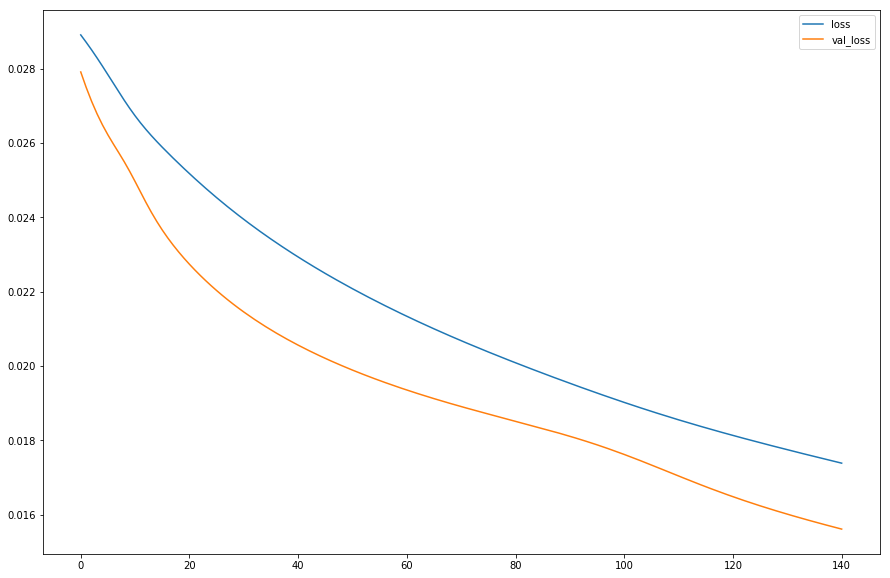

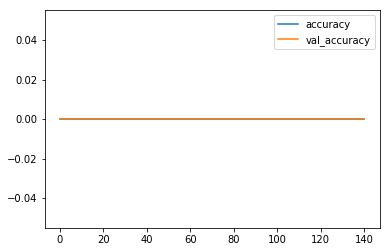

In [30]:
#print(history)
#print(history.history)
print(history.history.keys())
of = 9
plt.figure(figsize=(15.0,10.0))
plt.plot(history.history['loss'][of:], label="loss")
plt.plot(history.history['val_loss'][of:], label="val_loss")
plt.legend()
plt.show()
plt.plot(history.history['accuracy'][of:], label="accuracy")
plt.plot(history.history['val_accuracy'][of:], label="val_accuracy")
plt.legend()
plt.show()

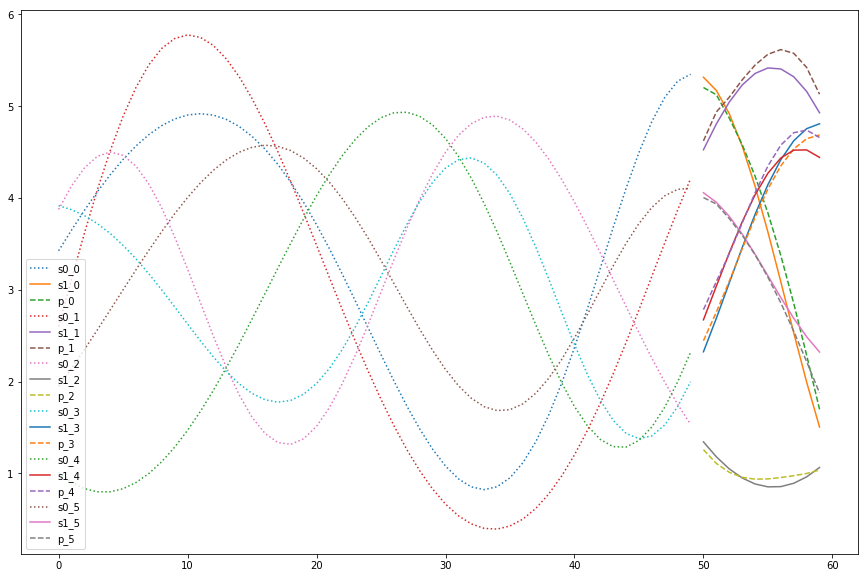

In [31]:
val = encoder.predict(test.batch(BATCH_SIZE, True))
#val = encoder.predict(val)
#val = encoder.predict(val)
#val = encoder.predict(val)
#val = encoder.predict(val)
#val = encoder.predict(val)

plt.figure(figsize=(15.0,10.0))
for i in range(0,6) :
    plt.plot(range(N_STEPS), list(test)[i][0], label="s0_" + str(i), linestyle=':')
    plt.plot(range(N_STEPS, N_STEPS+SEQ_LEN), list(test)[i][1], label="s1_" + str(i))
    plt.plot(range(N_STEPS, N_STEPS+SEQ_LEN), val[i], label="p_" + str(i), linestyle='dashed')
plt.legend()
plt.show()
